In [1]:
import os
import sys
import subprocess
import glob
import pathlib

# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True

    root = pathlib.Path("/content/t-route").resolve()
    subprocess.run(
        [
            "git",
            "clone",
            "-b",
            "segment-merge",
            "https://github.com/awlostowski-noaa/t-route.git",
        ]
    )

    ! pip install geopandas
    ! pip install zipfile
    ! pip install us
    ! pip install netcdf4
    ! pip install progressbar

except:
    ENV_IS_CL = False
    root = pathlib.Path("..").resolve()

fortran_source_dir = os.path.join(
    root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS"
)
sys.path.append(fortran_source_dir)
routing_v02_dir = os.path.join(root, "src", "python_routing_v02")
sys.path.append(routing_v02_dir)    
sys.path.append(os.path.join(root, "src", "python_framework_v02"))
sys.path.append(os.path.join(root, "src", "python_framework_v01"))

fortran_source_dir = os.path.join(
    root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS"
)
sys.path.append(fortran_source_dir)
routing_v02_dir = os.path.join(root, "src", "python_routing_v02")
sys.path.append(routing_v02_dir)
sys.path.append(os.path.join(root, "src", "python_framework_v02"))
sys.path.append(os.path.join(root, "src", "python_framework_v01"))

COMPILE_cython = False
# ! This will definitely work in the Google Colab environment, though may not work
# in your local envioronment.
if COMPILE_cython:

    subprocess.run(
        ["gfortran", "varPrecision.f90", "-c", "-o", "var_precision.o", "-O3", "-fPIC"],
        cwd=fortran_source_dir,
    )
    subprocess.run(
        [
            "gfortran",
            "MCsingleSegStime_f2py_NOLOOP.f90",
            "-c",
            "-o",
            "mc_single_seg.o",
            "-O3",
            "-fPIC",
        ],
        cwd=fortran_source_dir,
    )
    subprocess.run(
        [
            "gfortran",
            "pyMCsingleSegStime_NoLoop.f90",
            "-c",
            "-o",
            "pymc_single_seg.o",
            "-O3",
            "-fPIC",
        ],
        cwd=fortran_source_dir,
    )

    for obj_file in glob.glob(os.path.join(fortran_source_dir, "*.o")):
        print(obj_file)
        subprocess.run(["cp", obj_file, routing_v02_dir])

    if ENV_IS_CL:
        numpy_I = "/usr/local/lib/python3.6/dist-packages/numpy/core/include"
        py_I = "/usr/include/python3.6"
        py_lib = "/usr/include/python3.6"

    else:
        bin_exe = pathlib.Path(sys.executable)
        virtual_env_path = bin_exe.parents[1]
        py_lib = os.path.join(virtual_env_path, "lib")
        numpy_I = os.path.join(
            py_lib, "python3.6", "dist-packages", "numpy", "core", "include"
        )
        py_I = os.path.join(virtual_env_path, "include", "python3.6m")

    subprocess.run(
        [
            "cython",
            "-3",
            "-v",
            "-p",
            "--line-directives",
            "-Wextra",
            "--cleanup",
            "3",
            "mc_reach.pyx",
        ],
        cwd=routing_v02_dir,
    )
    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-Wno-unused-result",
            "-Wsign-compare",
            "-DNDEBUG",
            "-g",
            "-fwrapv",
            "-O3",
            "-fno-strict-aliasing",
            "-Wall",
            "-Wstrict-prototypes",
            "-fPIC",
            "-I",
            numpy_I,
            "-I",
            py_I,
            "-c",
            "mc_reach.c",
            "-o",
            "mc_reach.o",
        ],
        cwd=routing_v02_dir,
    )
    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-shared",
            "-L",
            py_lib,
            "var_precision.o",
            "mc_single_seg.o",
            "pymc_single_seg.o",
            "mc_reach.o",
            "-lgfortran",
            "-o",
            "mc_reach.cpython-36m-x86_64-linux-gnu.so",
        ],
        cwd=routing_v02_dir,
    )

# load needed scientific libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from itertools import chain
import requests
import zipfile
import io
import us
import time

# turn off warnings
import warnings
warnings.simplefilter("ignore")

# import t-route functions for network analysis
import nhd_network_utilities_v02 as nnu
import nhd_io
import nhd_network
import mc_reach
import network_dl
import nhd_network_augment as network_aug


# Notebook overview
This notebook illustrates a scheme developed by the National Water Center's Inland Hydraulics Group to limit the number of short stream segments in the NHDPlus data set. The cells below illustrate the application of python functions developed to prune and merge the NHDPlus network. Three realizations of the NHDPlus network are created: 1) native (as-is), 2) merged (short segments combined adjacent segments to make longer ones), and 3) a pruned and merged (merged, plus short headwater segments are removed from the network). We then conduct Muskingum-Cunge routing simulations to each of the network realizations and assess differences/similarities in simulated flows between networks. Preliminary results illustrate the pruning and merging short segments speeds up the wall clock timing of network-scale routing models, but affects the timing and shape of simulated flood waves, compared to simulations conducted on the native NHDPlus network.  


# Notebook domain: The Cape Fear River Basin, North Carolina
For this proof of concept, the model domain is restricted to the Cape Fear River Basin, North Carolina. The Cape Fear River flows from west to east, orginiating in North Carolina's Piedmont region and terminating in the Atlantic Ocean at Southport North Carolina. The Cape Fear is used extensively for commercial transportation, water supply (municipal and industrial), commercial fishing, and recreation. Additionally the river poses a flood hazard to two major port cities: Wilmington and Southport. In Southport, where the river debauches into the ocean, tidal storm surge dynamics complicate the timing, magnitude, and extent of flood conditions during hurricanes and tropical storms. 


## Loading, masking and preparing NHDPlus data for analysis
The cell below loads route-link data for the CONUS full-resolution NHDPlus network. The route-link dataset contains critical channel geometry and roughness parameters for every segment in the NHDPlus network. Moreover, the dataset contains connectivity data, specifically the destination segment of segment in the network (i.e. into which segment each segment flows). These data are then masked to extract only segments located within the Cape Fear River Basin, and prepared for further network analysis by selecting only those data attributes needed, here. A copy of the network data is retained for visualization purposes. 

In [2]:

# Create directory path variable for test/input/geo, where NHD data and masks are stored
test_folder = os.path.join(root, r"test")
geo_input_folder = os.path.join(test_folder, r"input", r"geo")

# Load network meta data for the Cape Fear Basin
supernetwork = "CapeFear_FULL_RES"
network_data = nnu.set_supernetwork_data(
    supernetwork=supernetwork, geo_input_folder=geo_input_folder
)

# if the NHDPlus RouteLink file does not exist, download it.
if not os.path.exists(network_data["geo_file_path"]):
    filename = os.path.basename(network_data["geo_file_path"])
    network_dl.download(network_data["geo_file_path"], network_data["data_link"])

# read-in NHD data, retain copies for viz- and full network analysis purposes
data = nhd_io.read(network_data["geo_file_path"]) 
data_full = data.copy() # copy of full resolution CONUS network
dat_geo = data.copy() # copy for graphical purposes

# select only the necessary columns needed for network analysis and computation
cols = [v for c, v in network_data.items() if c.endswith("_col")]
data = data[cols]

# set the Data Frame index (row labels) to the key column - "featureID"
data = data.set_index(network_data["key_col"])
dat_geo = dat_geo.set_index(network_data["key_col"])

# mask NHDNetwork to isolate test network - full resolution Cape Fear basin, NC
if "mask_file_path" in network_data:
    data_mask = nhd_io.read_mask(
        network_data["mask_file_path"], layer_string=network_data["mask_layer_string"],
    )
    data = data.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)
    dat_geo = dat_geo.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)

# sort data by index
data = data.sort_index()

# replace downstreams for terminal segments
data = nhd_io.replace_downstreams(data, network_data["downstream_col"], 0)

print("NHD data loaded, masked, and prepped")


NHD data loaded, masked, and prepped


## Visualize the Cape Fear River Basin with a map 
The cell below creates a GeoDataFrame of points from the route-link data. Each point corresponds to a specific stream segment in the network. A shapefile of North Carolina's state boundaries are imported, unzipped, and saved. Finally, a simple map displaying each segment of the network and state boarders is created and saved. 

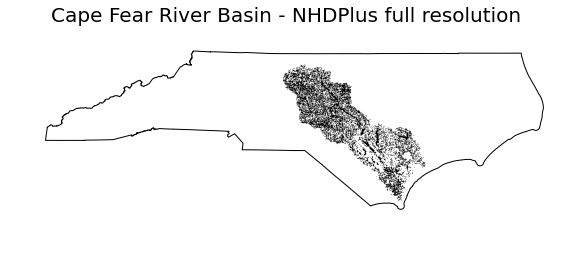

In [3]:
# create a pandas GeoDataFrame for viz purposes
gdf = gpd.GeoDataFrame(dat_geo, geometry=gpd.points_from_xy(dat_geo.lon, dat_geo.lat))

################################################
# Download North Carolina shapefile for basemap
################################################
shape_url = us.states.NC.shapefile_urls()["state"]
local_path = "../test/input/geo/NorthCarolina_state_shape"

# Download and extract shapefile
r = requests.get(shape_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=local_path)

# get extracted filenames
filenames = [
    y
    for y in sorted(z.namelist())
    for ending in ["dbf", "prj", "shp", "shx"]
    if y.endswith(ending)
]
dbf, prj, shp, shx = [filename for filename in filenames]

# load shapefile with GeoPandas
nc = gpd.read_file(local_path + "/" + shp)

################################################
# Create a map
################################################

# create a basemap
base = nc.plot(color="white", edgecolor="black")

# add our stream network, segments are represented as small points (nodes in the network)
gdf.plot(ax=base, markersize=0.01, color="black")

# crop the map extent
base.set_xlim(-85, -75)
base.set_ylim(33, 37)

# turn axes off
base.axis("off")

# get current figure and set size
fig = plt.gcf()
fig.set_size_inches(10, 15)

# add a title and display
plt.title("Cape Fear River Basin - NHDPlus full resolution", fontsize=20)

# display and save the map
plt.show()
fig.savefig("../doc/cape_fear_network.png", bbox_inches='tight')


## Short segments dominate segment length distributions
The cell below creates histogram plots showing the distribution of segment lengths in Cape Fear and CONUS domains of the NHDPlus network. 
- Distributions are heavily skewed to the right, with modal segment length of 1 meter. 
- 37% of all segments in the CONUS domain are shorter than 1 km, 16% are shorter than 300 meters.
- 53% of all segments in the Cape Fear domain are shorter than 1 km, 27% are shorter than 300 meters. 

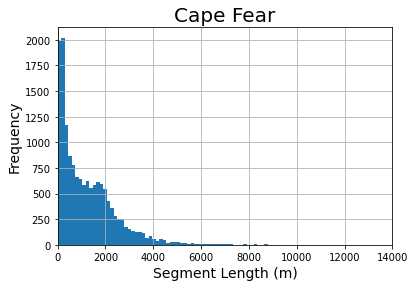

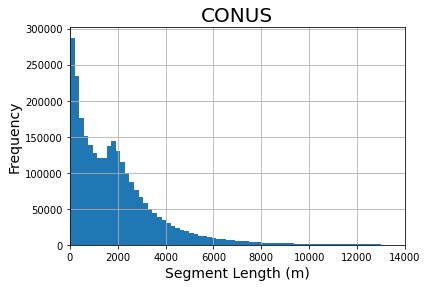

In [4]:
filenames = ["nhd_fullres_capefear_length_distribution.png", 
             "nhd_fullres_conus_length_distribution.png"]

titles = ["Cape Fear",
         "CONUS"]

for i, df in enumerate((data, data_full), 0):
    
    if i == 1:
        df.Length.hist(bins = 500)
    else:
        df.Length.hist(bins = 100)
    
    ax = plt.gca()
    ax.set_ylabel("Frequency", size=14)
    ax.set_xlabel("Segment Length (m)", size=14)
    plt.title(titles[i], fontsize=20)
    plt.xlim([0,14000])
    
    fig = plt.gcf()

    plt.show()
    fig.savefig("../doc/" + filenames[i], bbox_inches='tight')


# What do we mean by short? Define a threshold segment length
Before we go about pruning and merging the network to create new realizations, we must define what we mean by "short". In the cell below, define the threshold length (m), below which segments will be considered too short.

In [5]:
thresh = 300

# Pruning headwater segments
Headwater segments are defined as having no upstream connections. By pruning, we seek to remove headwater segments that are shorter than the threshold length and flow directly into a junction. The basic logic behind the pruning routine is as follows:

1. Identify all headwater-headwater junctions (i.e. junctions where two headwater segments merge together)
2. Is the shortest headwater segment flowing into the junction shorter than the threshold? 
    - if yes: prune the shortest headwater
    - if no: do nothing
3. Identify all headwater-midwater junctions (i.e junctions where a headwater segment merges with a non-headwater segment)
4. Is the headwater segment flowing into the junction shorter shorter than the threshold?
    - if yes: prune the headwater
    - if no: Are either of the midwater segments above or below the junction shorter than the threshold?
        - if yes: prune the headwater
        - if no: do nothing
        
The cell below conducts pruning in two steps. First, each segment in the network is classified as being either a headwater or non-headwater. Downstream connection dictionaries are created for headwaters and non-headwaters. Second, headwaters are pruned according the logic above, provided a user defined length threshold (see previous cell). 

In [10]:
# identify headwater and non-headwater (midwater) reaches (that also have a downstream connection)
hw_conn, non_hw_conn = network_aug.headwater_connections(data, 
                                                         network_data)

# Prune the network
print("Pruning headwaters...")

pruned_headwaters, data_pruned = network_aug.prune_headwaters(hw_conn, 
                                                              non_hw_conn, 
                                                              data, 
                                                              thresh)

print(
    "Done pruning! Removed",
    len(pruned_headwaters),
    "headwater segments, or",
    int(data.loc[pruned_headwaters].Length.sum() / 1000),
    " river km, from the network.",
)
print(
    "That is",
    int((data.loc[pruned_headwaters].Length.sum() / data.Length.sum()) * 100),
    "% of the total network length and",
    int(len(data.loc[pruned_headwaters]) / len(data[data.Length < thresh]) * 100),
    "% of segments shorter than the threshold."
)


Pruning headwaters...
Done pruning! Removed 762 headwater segments, or 1045  river km, from the network.
That is 5 % of the total network length, and 18 % of segments shorter than the threshold.


# Merge short segments with adjacent segments
Another way to avoid the ubiquity of short segments is to merge them with adjacent segments, creating longer segments. This is done by first parsing the network into reaches (linear combinations of segments between junctions). For each reach, we then identify segments shorter than the threshold length. Short segments are merged with adjacent segments until a) no one segment in the reach is shorter than the threshold, or b) no segments are left to merge (i.e. the reach is composed of a single short segment). 

Once a segment is merged with its neighbor, we must determine its new geometric properties. There are many ways to do this, but for the time being we use a length-weighted average approach. For example, the bottom width of the newly merged segment is the length weighted average of the bottom width of the segments merged together.   

Likewise, we must appoint newly merged segments an index (link ID). As a rule, newly merged segments carry the index (link ID) of the downstream-most segment involved in the merger. So, if segment A (link ID = 0001) is merged with downstream segment B (link ID = 0002), the newly created segment with have a link ID of 0002. Once new link IDs are appointed, network connections are updated. Following the example, segment A's link ID no longer exists after the merger. So, any segments previously flowing into segment A, now flow into segment B. 

The cell below conducts the merging routine for the native NHDPlus network and pruned NHDPlus network, resulting in the creation of a merged network and a pruned and merged network. 

In [11]:
##################################################
# Merge segments in native network
##################################################
print("Merging segments in native NHDPlus Full Res data...")
ts = time.time()
data_merged, qlat_dest_merged = network_aug.segment_merge(data,
                                              data,
                                              network_data,
                                              thresh,
                                              pruned_segments = [])
tf = time.time()
print("Merging complete, that took", round((tf - ts)/60, 2), "minutes")

##################################################
# Merge segents in pruned network
##################################################
print("Merging segments in pruned NHDPlus Full Res data...")
ts = time.time()
data_pruned_merged, qlat_dest_pruned_merged = network_aug.segment_merge(data,
                                                            data_pruned,
                                                            network_data,
                                                            thresh,
                                                            pruned_segments = pruned_headwaters)
tf = time.time()
print("Merging complete, that took", round((tf - ts)/60, 2), "minutes")

Merging segments in native NHDPlus Full Res data...
Merging complete, that took 1.13 minutes
Merging segments in pruned NHDPlus Full Res data...
Merging complete, that took 1.11 minutes


## Segment (pruning and) merging removes *most* of the short segments
The cell below creates segment length histograms for each of the three network realizations created above. The x-axis of each histogram is restricted to < 1000 meters to emphasize differences on the left end of the segment length distribution. Clearly, the pruning and merging processes reduce the number of segments shorter than the threshold length. For a threshold length of 300 meters:

- The native network contained 4077 segments shorter than 300 meters
- The merged network contains only 1100 segments shorter than 300 meters
- The pruned/merged network contains only 342 segments shorter than 300 meters

Why do some short segments still remain? Remaining short segments are "orphaned" single-segment reaches shorter than the threshold length. Recall that reaches are linear combinations of segments *between two junctions*. If a reach is only composed of one segment, and that segment is short, there is nothing we can do about it without changing the orientation of junctions (e.g. snapping two junction points together). 

The pruned/merged network contains the fewest number of short segments because the logic controlling headwater trimming aims to limit the number of orphaned short single-segment reaches. Recall that a headwater is trimmed if is longer than the threshold length and the midwater segments flowing into or out of the junction are shorter than the threshold. This logic ends up removing one of the junctions that would otherwise constrain a short single segment reach.

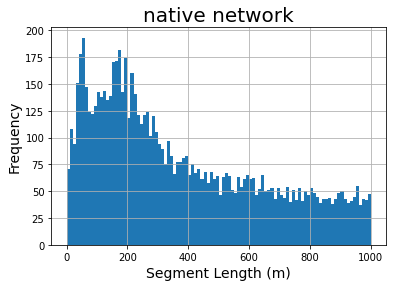

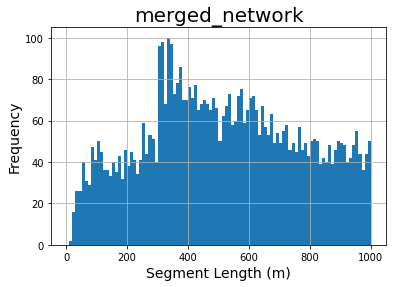

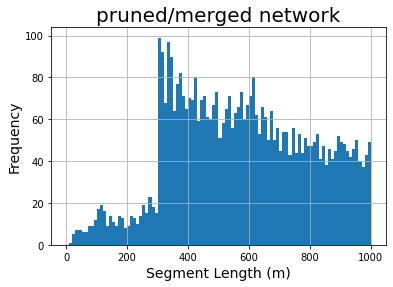

In [20]:
filenames = ["capefear_native_length_distribution.png", 
             "capefear_merged_length_distribution.png",
             "capefear_pruned_merged_length_distribution.png"]

titles = ["native network",
         "merged_network",
         "pruned/merged network"]

for i, df in enumerate((data, data_merged, data_pruned_merged), 0):
    
    df.Length.hist(bins = 100, range = [0,1000])
    
    ax = plt.gca()
    ax.set_ylabel("Frequency", size=14)
    ax.set_xlabel("Segment Length (m)", size=14)
    
    plt.title(titles[i], fontsize=20)

    fig = plt.gcf()

    plt.show()
    fig.savefig("../doc/" + filenames[i], bbox_inches='tight')


# How does pruning and merging affect routing simulations?
Ok - so we've create new realizations of the NHDPlus network for the Cape Fear River Basin, so what? Below, we test how new network realizations affect flood routing simulations. We assess how the merged and pruned/merged networks affect wall-clock times and flood wave dynamics, relative to the native network. 

## Simulation time domain
We will set up a 150 day routing simulation with 1-hour timesteps (3600 seconds). Additionally, we specify four locations to compare flow simulations. 

In [ ]:
# number of simulated timesteps
nts = 3600

# duration of each timestep (seconds)
dt = 3600

# specific sites at which to analyze results
sites = {"Southport": 8835402,
         "Wilmington": 10529081,
         "Elizabethtown": 8831808,
         "Lillington": 8846907}

## A function to build an artificial lateral inflow series

In [ ]:
def step_qlats(data, nsteps, qlat):

    ##################################################
    # Create lateral inflow series, repeat on every 
    # segment in the network
    ##################################################
        
    q1 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q2 = np.full((len(data.index), nsteps // 10), qlat, dtype="float32")
    q3 = np.full((len(data.index), nsteps // 10), qlat, dtype="float32")
    q4 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q5 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q6 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q7 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q8 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q9 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")
    q10 = np.full((len(data.index), nsteps // 10), 0, dtype="float32")

    q = np.concatenate((q1, q2, q3, q4, q5, q6, q7, q8, q9, q10), axis=1)

    ql = pd.DataFrame(q, index=data.index, columns=range(nsteps))
    
    return ql

## A function to incorporate lateral inflows from merged/pruned segments into next downstream segment

In [ ]:
def qlat_merger_adjust(ql, ql_destinations):
    
    ql_merged = ql.copy()
    
    for i, (seg, dest) in enumerate(ql_destinations.items()):
        
        # add lateral inflows from pruned/merged segment to downstream destination
        series = ql_merged.loc[[seg, dest[0]]].sum(axis = 0)
        series.name = dest[0]
        
        ql_merged.loc[dest] = pd.DataFrame(series).T
     
    # drop pruned/merged segments
    ql_merged = ql_merged.drop(ql_destinations.keys())
    
    return ql_merged

## Build lateral inflow data for each network realization

In [ ]:
# create the native lateral inflow data
qlat_native = step_qlats(data, nts, 10.0)

# adjust lateral inflows data to account for pruning and merging
qlat_merged = qlat_merger_adjust(qlat_native, qlat_dest_merged)
qlat_pruned_merged = qlat_merger_adjust(qlat_native, qlat_dest_pruned_merged)

# plot lateral inflow series
qlat_native.iloc[1].plot(color="r", linewidth=2)


## Plot lateral inflow series for single segment

In [ ]:
ax = plt.gca()
ax.set_title("Lateral Inflow Loading", size=20)
ax.set_ylabel("Lateral Inflow (cms per segment)", size=14)
ax.set_xlabel("Simulated Timestep", size=14)

fig = plt.gcf()
plt.show()
fig.savefig("../doc/lateral_inflow_series.png", bbox_inches='tight')

## A function to execute network simulations with Muskingum-Cunge routing model

In [ ]:
def simulate_network(tail_water, data, dt, nts, qlats, network_data):
    
    # extract connections and build reaches
    conn, rconn = network_aug.network_connections(data, network_data)
    subreachable, subreaches = network_aug.build_reaches(rconn)
    
    # initialize a list to store results
    results = []
    
    # create a list of individual segments in the network
    reach = subreaches[tail_water]
    r = list(filter(None, chain.from_iterable(reach)))
    
    # add a dt column to the data DataFrame
    data["dt"] = dt

    # rename columns to specific variable names expected by mc_reach.compute_network
    column_rename = {
        network_data["length_col"]: "dx",
        network_data["topwidth_col"]: "tw",
        network_data["topwidthcc_col"]: "twcc",
        network_data["bottomwidth_col"]: "bw",
        network_data["manningncc_col"]: "ncc",
        network_data["slope_col"]: "s0",
        network_data["ChSlp_col"]: "cs",
        network_data["manningn_col"]: "n",
    }

    data = data.rename(columns=column_rename)

    # change variables to type float32, as expected by mc_reach.compute_network
    data = data.astype("float32")

    # prep parameter and lateral inflow data to be fed to routing model
    data_sub = data.loc[
        r, ["dt", "bw", "tw", "twcc", "dx", "n", "ncc", "cs", "s0"]
    ].sort_index()
    
    # !!! something strange is happening, here
    qlat_sub = qlats.loc[r].sort_index()
    
    print("Total lateral inflows:",qlat_sub.sum().sum())

    # compute the network routing, calculate (flow, depth, and velocity)
    start_time = time.time()
    results.append(
        mc_reach.compute_network(
            nts,
            reach,
            subnets[tail_water],
            data_sub.index.values.astype("int64"),
            data_sub.columns.values,
            data_sub.values,
            qlat_sub.values,
        )
    )
    end_time = time.time()
    
    # simulation time
    timing = end_time - start_time
    
    # create a multi-index DataFrame with flow, depth, and velocity simulations
    fdv_columns = pd.MultiIndex.from_product([range(nts), ["q", "v", "d"]])
    flowveldepth = pd.concat(
        [pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False
    )
    flowveldepth = flowveldepth.sort_index()

    return flowveldepth, timing, qlat_sub
    

## Run routing simulation on each network realization

In [ ]:
tw = 8835402

print("Simulating the native network")
flowveldepth_native, timing, qlat_sub = simulate_network(tw, 
                                                         data, 
                                                         dt, 
                                                         nts, 
                                                         qlat_native, 
                                                         network_data)
print("Simulation complete, that took", round((timing)/60, 2), "minutes")

print("Simulating the merged network")
flowveldepth_merged, timing, qlat_sub = simulate_network(tw, 
                                                         data_merged, 
                                                         dt, 
                                                         nts, 
                                                         qlat_merged, 
                                                         network_data)
print("Simulation complete, that took", round((timing)/60, 2), "minutes")

print("Simpulating the pruned and merged network")
flowveldepth_pruned_merged, timing, qlat_sub_pruned_merged = simulate_network(tw, 
                                                                              data_pruned_merged, 
                                                                              dt, 
                                                                              nts, 
                                                                              qlat_pruned_merged, 
                                                                              network_data)
print("Simulation complete, that took", round((timing)/60, 2), "minutes")

## Visualize simulation on the native NHDPlus network with gif animation

In [ ]:
import gif
from mpl_toolkits.axes_grid1 import make_axes_locatable

# find segments in the Cape Fear Basin
tw = 8835386
conn = nhd_network.extract_connections(data, network_data["downstream_col"])
rconn = nhd_network.reverse_network(conn)
subreachable = nhd_network.reachable(rconn)
network_segs = subreachable[tw]

# network geodata framee
network_gdf = gdf.loc[gdf.index.isin(network_segs)]
network_flows = flowveldepth_native.loc[:, (slice(None), "q")]

@gif.frame
def plot(tstep):

    first_flow = network_flows.loc[:, ((tstep), "q")]

    joined_gdf = network_gdf.join(first_flow)
    joined_gdf = joined_gdf.rename(columns={joined_gdf.columns[-1]: "flow"})

    # create a figure showing spatial variations in simulated flow and the lateral flow loading
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(4, 3)
    ax1 = fig.add_subplot(gs[0:2, :])  # we will make a map on ax1
    ax2 = fig.add_subplot(gs[2:3, :])  # we will make a line plot on ax2

    # need to adjust the size and position of the map colorbar
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # plot the spatial variation in simulated flow rate, across all stream segments in the network
    joined_gdf.plot(
        markersize=0.1,
        column="flow",
        cmap="PuBu",
        legend=True,
        vmin=0,
        vmax=2000,
        ax=ax1,
        cax=cax,
        legend_kwds={"label": "Flow (cms)", "orientation": "vertical"},
    )

    # map title and axis controls
    ax1.set_title("Cape Fear River Basin", size=20)
    ax1.axis("off")

    # plot the timeseris of lateral inflow loading
    qlat_native.iloc[1][0:tstep].plot(ax=ax2, color="r", linewidth=2) 
    ax2.set_xlim([0, 3600])
    ax2.set_ylim([0, 11])
    ax2.set_title("Lateral Inflow Loading", size=20)
    ax2.set_ylabel("Lateral Inflow (cms per node)", size=14)
    ax2.set_xlabel("Simulated Timestep", size=14)

    # adjsut the figure size
    fig.set_size_inches(10, 10)

frames = []
for i in range(0, 2025, round(nts / 160)):

    frame = plot(i)

    frames.append(frame)

if ENV_IS_CL:
    os.chdir("/content/t-route/doc/")
    gif.save(frames, "cape_fear.gif", duration=10)

else:
    gif.save(frames, "../doc/cape_fear.gif", duration=10)

## A function to reshape simulation output DataFrame 

In [ ]:
def reshape_output(flowveldepth, sites, sim_type):
    
    # Subset model output and reshape dataframe
    flows = flowveldepth.loc[sites.values(), (slice(None), "q")]
    flows = flows.T.reset_index(level = [0,1])

    flows.columns = flows.columns.map(str)
    
    flows.rename(columns = {"level_0": "Timestep", "level_1": "Parameter"}, inplace = True)

    for key, value in sites.items():
        
        flows.rename(columns = {str(value): key}, inplace = True)
        
    flows = flows.melt(id_vars=["Timestep"],
                       value_vars = list(sites.keys()),
                       var_name="City", 
                       value_name="Flow")

    flows["Simulation"] = sim_type
    
    return flows

## Reshape simulation output

In [ ]:
flows_native = reshape_output(flowveldepth_native, sites, sim_type = "native")
flows_merged = reshape_output(flowveldepth_merged, sites, sim_type = "merged")
flows_pruned_merged = reshape_output(flowveldepth_pruned_merged, sites, sim_type = "pruned/merged")

## Plot simulation results at key sites in the basin, native NHDPlus network

In [ ]:
fig, ax = plt.subplots()
for name, group in flows_native.groupby('City'):
    group.plot(x="Timestep", y='Flow', ax=ax, label=name)

plt.ylabel("Flow (cms)")
plt.xlabel("Timestep")
plt.title("Native network simulation")
plt.xlim([0, 3600])

fig = plt.gcf()
plt.show()
fig.savefig("../doc/native_simulation_alltime.png", bbox_inches='tight')

## Compare simulations on the rising limb at two sites: Southport and Wilmington

In [ ]:
df_all_sim = flows_native.append([flows_merged, flows_pruned_merged])

# Southport simulation comparison
df = df_all_sim.groupby('City').get_group('Southport')
fig, ax = plt.subplots()
for name, group in df.groupby('Simulation'):
    group.plot(x="Timestep", y='Flow', ax=ax, label=name)

plt.ylabel("Flow (cms)")
plt.xlabel("Timestep")
plt.title("Southport - near basin outlet")
plt.xlim([0, 1000])
plt.show()
fig.savefig("../doc/southport_rising_limb.png", bbox_inches='tight')

# Wilmington simulation comparison
df = df_all_sim.groupby('City').get_group('Wilmington')
fig, ax = plt.subplots()
for name, group in df.groupby('Simulation'):
    group.plot(x="Timestep", y='Flow', ax=ax, label=name)

plt.ylabel("Flow (cms)")
plt.xlabel("Timestep")
plt.title("Wilmington - shortest network length")
plt.xlim([0, 1000])
plt.show()
fig.savefig("../doc/wilmington_rising_limb.png", bbox_inches='tight')
